In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [5]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *

### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66.3 
lon_max = -53.5
lat_min = 31.7
lat_max = 44.5

datadir="/dmidata/users/maxb/NATL_dataset"
datamodule = BaseDataModule(input_da=load_altimetry_data(datadir+"/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 15, 'lat': 128, 'lon': 128},
                                     'strides': {'time': 1, 'lat': 128, 'lon': 128},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 1, 'num_workers': 1},
                            grad=False,
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2)
datamodule.setup()

Norm stats (0.3047108663749711, 0.3879814586804132)


torch.Size([1, 15, 128, 128])


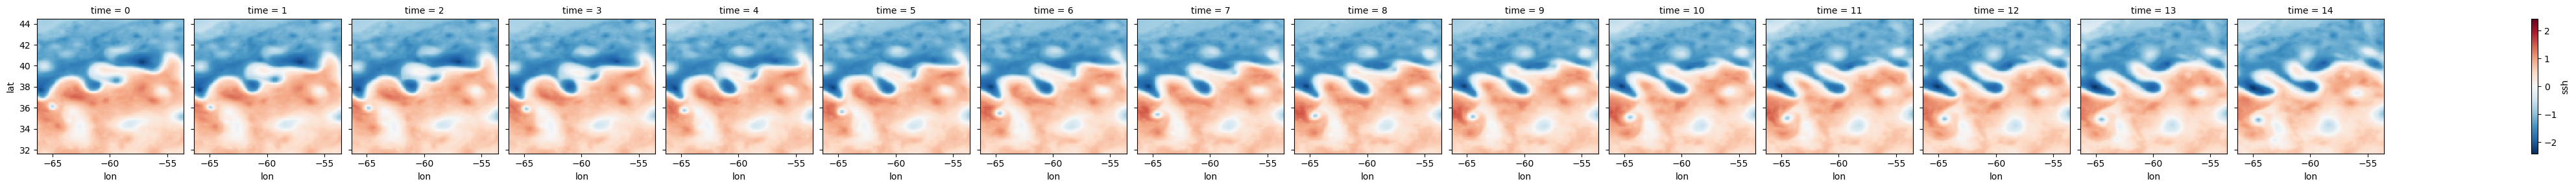

In [6]:
# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=15)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# Observational cost and Prior cost

In [4]:
class BaseObsCost(nn.Module):
    def __init__(self, w=1) -> None:
        super().__init__()
        self.w=w

    def forward(self, state, y):
        msk = y.isfinite()
        return self.w * F.mse_loss(state[msk], y.nan_to_num()[msk])

class BilinAEPriorCost(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad=True, nt=None):
        super().__init__()
        self.nt = nt
        self.bilin_quad = bilin_quad
        self.conv_in = nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.bilin_1 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.conv_out = nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def forward_ae(self, x):
        x = self.down(x)
        x = self.conv_in(x)
        x = self.conv_hidden(F.relu(x))

        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )
        x = self.up(x)
        return x

    def forward(self, state):
        return F.mse_loss(state, self.forward_ae(state))

# Define the solver (Diff)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(
            -torch.arange(half_dim, dtype=torch.float32, device=t.device) * 
            torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        )
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class TimeMLP(nn.Module):
    def __init__(self, time_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(time_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
        )

    def forward(self, t_emb):
        return self.mlp(t_emb)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )
        self.time_proj = nn.Linear(time_emb_dim, out_channels)

    def forward(self, x, t_emb):
        h = self.conv(x)
        time = self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        return h + time

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.block = ConvBlock(in_channels, out_channels, time_emb_dim)
        self.downsample = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

    def forward(self, x, t_emb):
        h = self.block(x, t_emb)
        return self.downsample(h), h

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.block = ConvBlock(in_channels + out_channels , out_channels, time_emb_dim)

    def forward(self, x, skip, t_emb):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        return self.block(x, t_emb)

class ConsistencyUNet(nn.Module):
    def __init__(self, in_channels, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_embed = SinusoidalTimeEmbedding(time_emb_dim)
        self.time_mlp = TimeMLP(time_emb_dim * 2, time_emb_dim)

        self.enc1 = DownBlock(3*in_channels, base_channels, time_emb_dim)
        self.enc2 = DownBlock(base_channels, base_channels * 2, time_emb_dim)
        self.enc3 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim)

        self.middle = ConvBlock(base_channels * 4, base_channels * 4, time_emb_dim)

        self.dec3 = UpBlock(base_channels * 4, base_channels * 2, time_emb_dim)
        self.dec2 = UpBlock(base_channels * 2, base_channels, time_emb_dim)
        self.dec1 = UpBlock(base_channels, base_channels, time_emb_dim)

        self.final = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x_t, y, t, t_prime):
        mask_obs = ~torch.isnan(y)
        y = torch.nan_to_num(y)  
        # Combine time and t_prime embeddings
        t_emb = self.time_embed(t)
        t_prime_emb = self.time_embed(t_prime)
        time_input = torch.cat([t_emb, t_prime_emb], dim=-1)
        time_feat = self.time_mlp(time_input)

        #x1, skip1 = self.enc1(x_t, time_feat)
        x1, skip1 = self.enc1(torch.cat((x_t, y, mask_obs), 1), time_feat)
        x2, skip2 = self.enc2(x1, time_feat)
        x3, skip3 = self.enc3(x2, time_feat)

        mid = self.middle(x3, time_feat)

        d3 = self.dec3(mid, skip3, time_feat)
        d2 = self.dec2(d3, skip2, time_feat)
        d1 = self.dec1(d2, skip1, time_feat)

        return self.final(d1)  # This approximates g_phi(x_t, t, t')

In [12]:
class GradSolver_Diff(nn.Module):
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2, reset_state=True, **kwargs):
        super().__init__()
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod

        self.steps = np.linspace(1,0.001,n_step)
        self.lr_grad = lr_grad

        self._grad_norm = None
        self.reset_state = reset_state
        self.lambda_reg = torch.nn.Parameter(torch.ones((1)))
        
    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init
        return (torch.randn(batch.tgt.size(),device=device).detach() \
                * marginal_prob_std(torch.ones(batch.tgt.shape[0], device=device),sigma=25)[:, None, None, None]).requires_grad_(True)

    def var_cost(self, state, y):
        var_cost = self.lambda_reg*self.prior_cost(state) + self.obs_cost(state, y)
        return var_cost
        
    def solver_step(self, state, y, step1, step2):
        #var_cost = self.var_cost(state, y)
        #grad = torch.autograd.grad(var_cost, state, create_graph=True)[0]
        #gmod = self.grad_mod(grad, step1, step2)
        gmod = self.grad_mod(state, y, step1, step2)
        return state - gmod # + compute_sigma_integral(step1, step2, steps=100, sigma_min=0.01, sigma_max=25.0) * torch.randn_like(x).to(device)

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            #if self.reset_state:
            #    self.grad_mod.reset_state(batch.input)
            all_steps = []
            for i in range(len(self.steps)-1):
                step1 = self.steps[i]
                step2 = self.steps[i+1]
                state = self.solver_step(state, batch.input,
                                         step1=torch.tensor(step1).float().repeat(batch.tgt.size()[0]).to(device),
                                         step2=torch.tensor(step2).float().repeat(batch.tgt.size()[0]).to(device))
                #if not self.training:
                    #state = state.detach().requires_grad_(True)
                state = state.detach().requires_grad_(True)
                all_steps.append(state.detach())

        return state, all_steps

# Diffusion training

In [13]:
import functools

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The standard deviation.
  """
  #t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return sigma**t

def compute_sigma_integral(t_k, t_k_N, steps=100, sigma_min=0.01, sigma_max=50.0):
    """
    Compute Σ = ∫_{t_k-N}^{t_k} σ(t)^2 dt for each sample in a batch.
    
    Args:
        t_k: Tensor of shape (B,) — current times
        t_k_N: Tensor of shape (B,) — previous times
        steps: Number of integration steps (larger = more accurate)
        sigma_min, sigma_max: parameters of the VE-SDE
        
    Returns:
        sigma_integral: Tensor of shape (B,) — estimated Σ values
    """
    B = t_k.shape[0]
    device = t_k.device

    # Create a uniform grid of integration points between t_k_N and t_k
    t_grid = torch.linspace(0, 1, steps, device=device).unsqueeze(0)  # shape (1, steps)
    t_vals = t_k_N.unsqueeze(1) + (t_k - t_k_N).unsqueeze(1) * t_grid  # shape (B, steps)

    # Evaluate σ(t)^2 at each time point
    sigma_vals = diffusion_coeff(t_vals, 25) ** 2

    # Approximate integral using the trapezoidal rule
    dt = (t_k - t_k_N).unsqueeze(1) / (steps - 1)
    integral = torch.sum(sigma_vals, dim=1) - 0.5 * (sigma_vals[:, 0] + sigma_vals[:, -1])
    sigma_integral = integral * dt.squeeze(1)  # shape (B,)
    sigma_integral.requires_grad = True
    
    return sigma_integral
    
def loss_fn(solver, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """

  mask = ~torch.isnan(x)  # mask is True where x is not NaN
  x = torch.nan_to_num(x)  
    
  random_t1 = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps

  # Sample random_t2 in (random_t1, 1)
  random_margin = (1. - random_t1) * torch.rand_like(random_t1)  # a random amount above t1
  random_t2 = random_t1 + random_margin * (1 - eps)

  # consistency paired trick with shared noise
  z = torch.randn_like(x).to(device)
  z.requires_grad = True
  
  # std1 is lower than std2
  std1 = marginal_prob_std(random_t1)
  std2 = marginal_prob_std(random_t2)
  # perturbed_x1 is then less noisy than perturbed_x2
  perturbed_x1 = x + z * std1[:, None, None, None]
  perturbed_x2 = x + z * std2[:, None, None, None]

  # score integral: learn how to go from perturbed_x2 to perturbed_x1
  #var_cost = solver.var_cost(perturbed_x2, y)
  #grad = torch.autograd.grad(var_cost, perturbed_x2, create_graph=True)[0]
  #score_integral = solver.grad_mod(grad, random_t2, random_t1)
  score_integral = solver.grad_mod(perturbed_x2, y,  random_t2, random_t1)
  sigma_integral = compute_sigma_integral(random_t2, random_t1, steps=100, sigma_min=0.01, sigma_max=25.0)

  loss = (score_integral - (perturbed_x2 - perturbed_x1))**2/sigma_integral[:, None, None, None]

  # Step 3: Apply the mask
  loss = loss * mask.float()  # Only consider non-NaN pixels  
  # Step 4: Compute the mean loss over valid pixels
  loss = torch.mean(torch.sum(loss, dim=(1, 2, 3)))  # Sum over spatial dimensions
  #valid_pixel_count = torch.sum(mask.float(), dim=(1, 2, 3))  # Count valid pixels
  #loss = loss / valid_pixel_count  # Normalize loss by valid pixel count
  #loss = torch.mean(loss)  # Average over the batch
  
  return loss

sigma =  25.0#@param {'type':'number'}
#sigma = 5.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [14]:
device = 'cuda'

# state only
solver = GradSolver_Diff(n_step=5,
                    lr_grad=1e-3,
                    prior_cost = BilinAEPriorCost(dim_in=9,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                    obs_cost = BaseObsCost(),
                    grad_mod = ConsistencyUNet(in_channels=9, base_channels=64)).to(device)

# Training

In [15]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss
    
n_epochs =  100000#@param {'type':'integer'}
lr = 5e-4 #@param {'type':'number'}

"""
for param in solver.grad_mod.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, solver.parameters()), lr=lr)
"""
optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
        ])
accumulation_steps = 4
optimizer.zero_grad()

reload = True
if reload:
    ckpt = torch.load('../ckpt/ckpt_4dvarNet_diff.pth', map_location=device)
    solver.load_state_dict(ckpt)

tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
  avg_loss_diff = 0.
  avg_loss_prior = 0.
  num_items = 0
  for i, batch in enumerate(data_loader):
    batch = batch._replace(input=(batch.input).to(device))
    batch = batch._replace(tgt=(batch.tgt).to(device))
    loss_diff = loss_fn(solver, batch.tgt, batch.input, marginal_prob_std_fn)
    #prior_cost = solver.prior_cost(batch.tgt)
    loss = loss_diff #+ 10000*prior_cost
    optimizer.zero_grad()
    if loss is not None:
        loss.backward()
        
    if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

    avg_loss_diff += loss_diff.item() * batch.tgt.shape[0]
    #avg_loss_prior += prior_cost.item() * batch.tgt.shape[0]
    num_items += batch.tgt.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss Diff: {:5f}'.format(avg_loss_diff / num_items))# + "\n" + 
                             #'Average Loss Prior: {:5f}'.format(avg_loss_prior / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(solver.state_dict(), '../ckpt/ckpt_4dvarNet_diff.pth')

FileNotFoundError: [Errno 2] No such file or directory: '../ckpt/ckpt_4dvarNet_diff.pth'

# Test of the model

/tmp/ipykernel_2494248/1254128212.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('../ckpt/ckpt_4dvarNet_diff.pth', map_location=device)


0
1


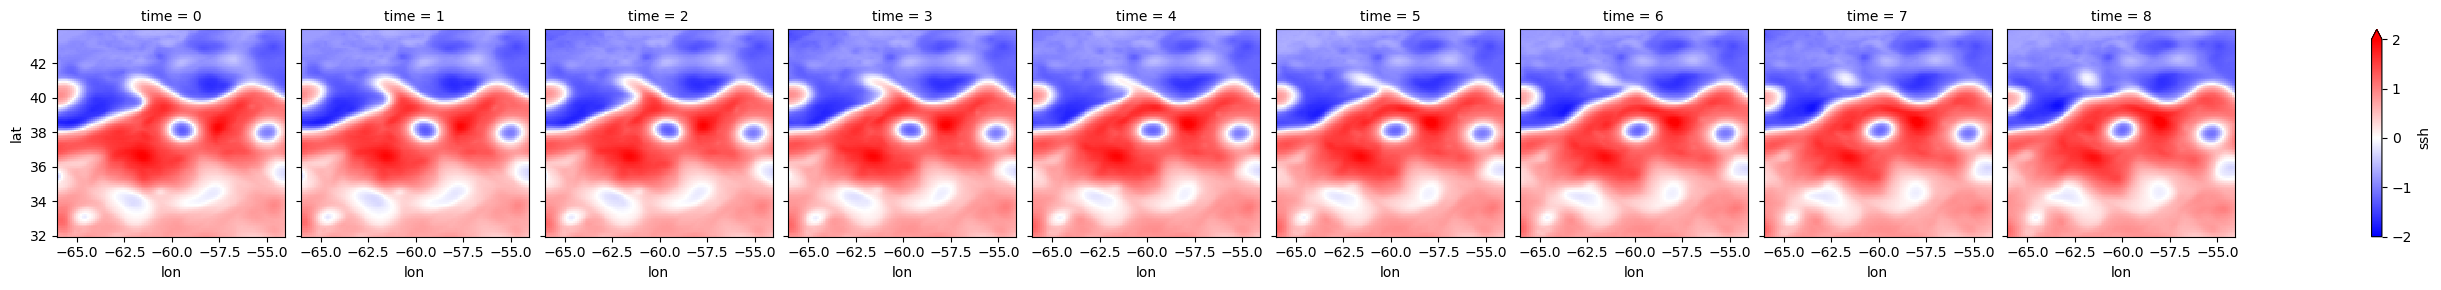

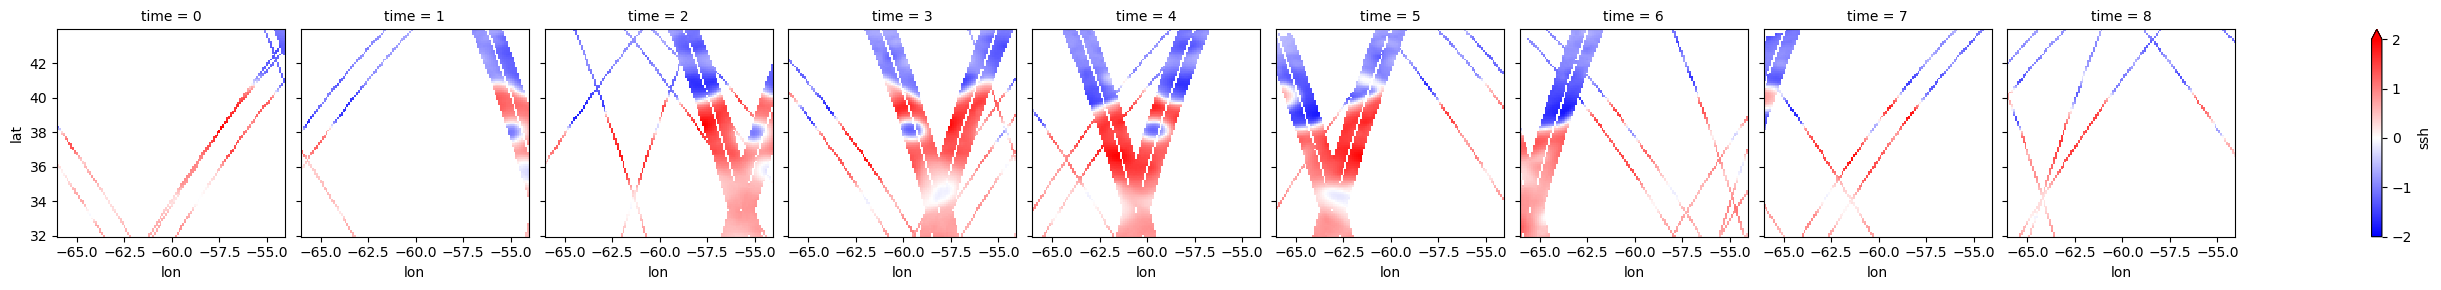

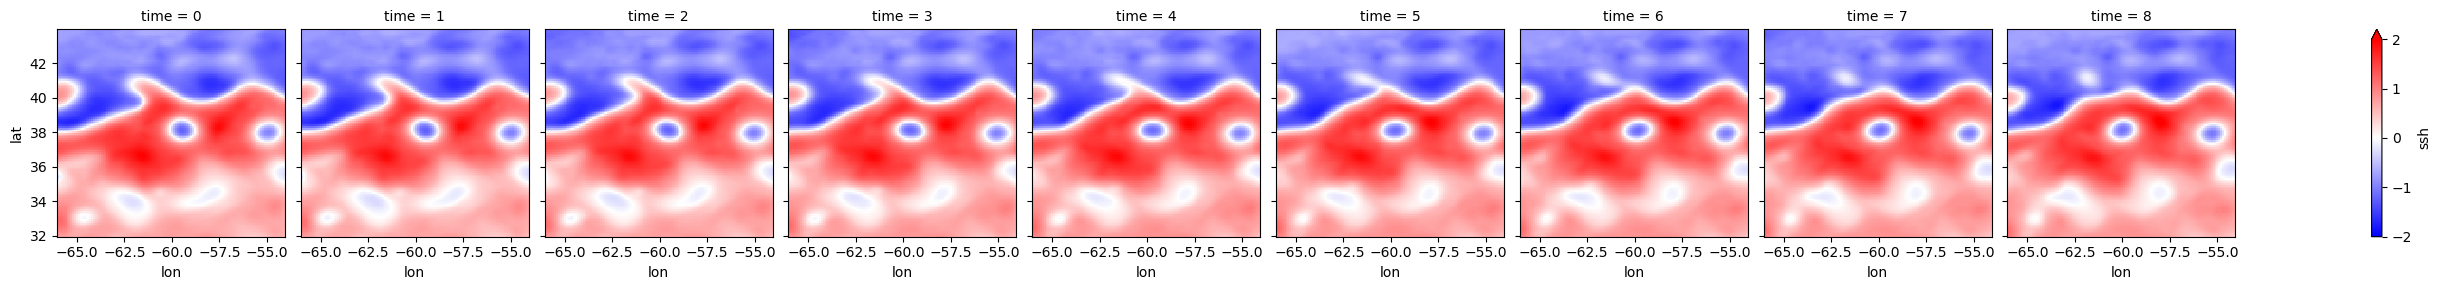

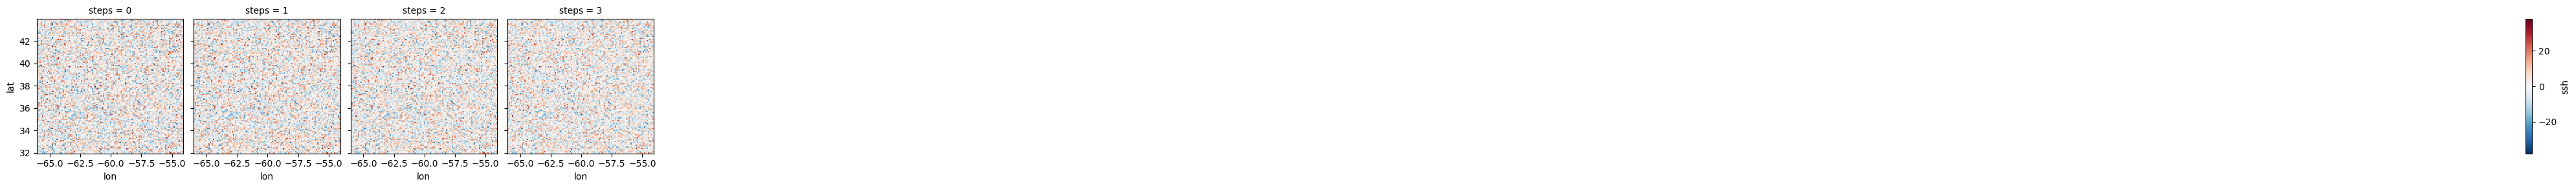

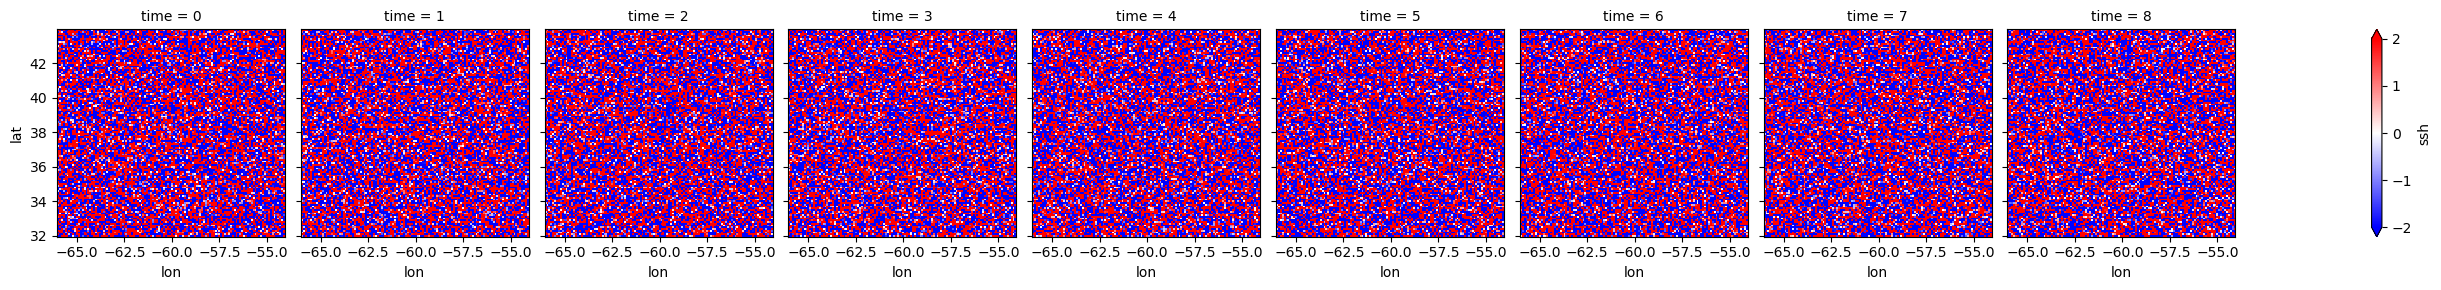

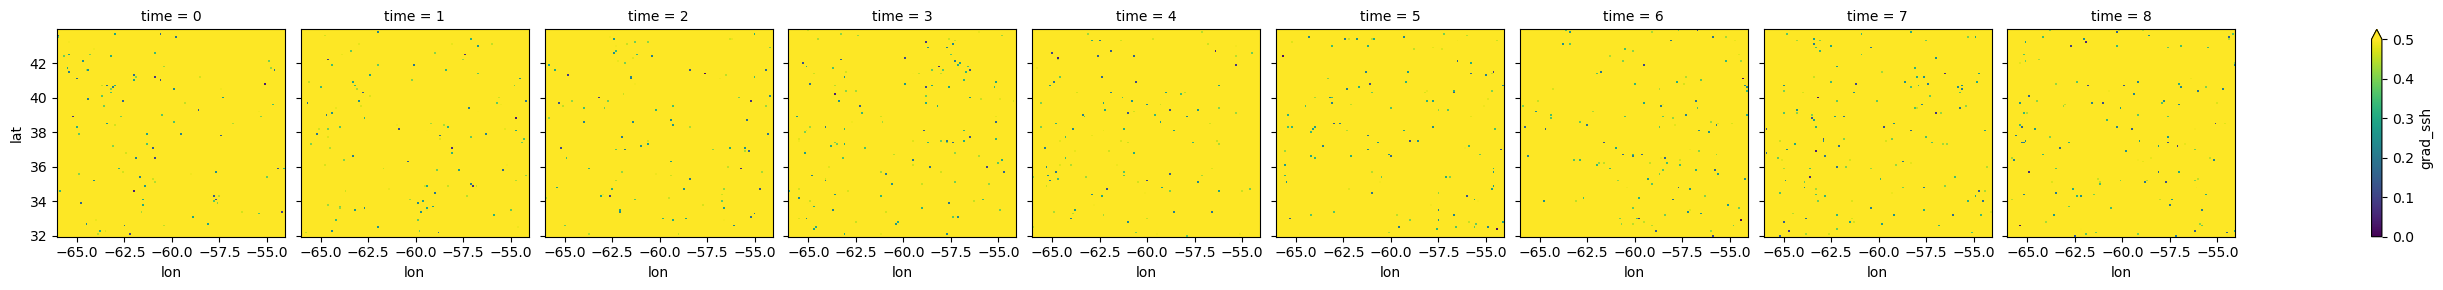

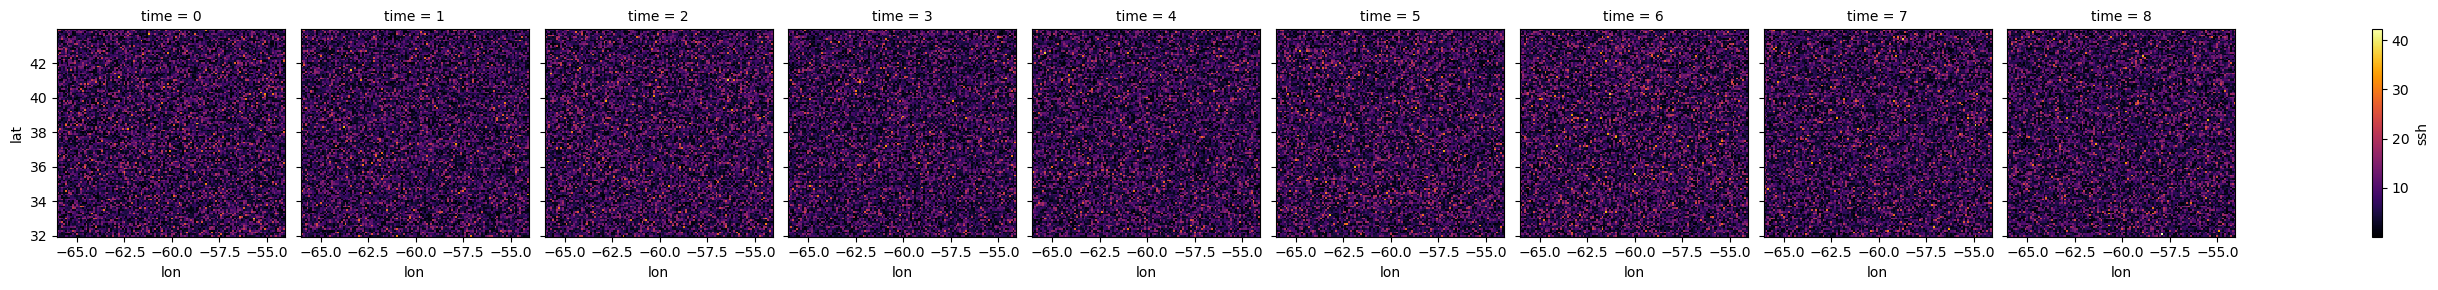

In [19]:
# test
from IPython.display import clear_output
ckpt = torch.load('../ckpt/ckpt_4dvarNet_diff.pth', map_location=device)
solver.load_state_dict(ckpt)

from kornia.filters import sobel

k = 3
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.input[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),(solver.prior_cost.forward_ae(test_batch.tgt.to(device)))[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)

test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

out, all_steps = solver(test_batch)
all_steps = torch.stack(all_steps,dim=1)
xr.Dataset(data_vars={'ssh':(('steps','lat','lon'),all_steps[5,:,4,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='steps',col_wrap=15)#, vmin=-2, vmax=2)


out = []
for i in range(2):
    print(i)
    out.append(solver(test_batch)[0].detach())

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[0][5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)

xr.Dataset(data_vars={'grad_ssh':(('time','lat','lon'),sobel(out[0])[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).grad_ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),torch.std(torch.stack(out,dim=0),dim=0)[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',cmap=plt.cm.inferno)